# Variational Autoencoder (VAE)

is a type of **generative AI model** that learns a **probabilistic representation** of data in a **latent space**, and can be used to **generate new, realistic data** similar to the ones from the training sample.


**Applications**: VAE has been used in Image generation, Data augmentation(e.g., generating additional training data for tasks where data is scarce), Anomaly detection (e.g., identifying rare or unusual samples that deviate from the learned distribution), Feature learning (e.g., learning useful representations of data that can be used for downstream tasks).



In the code below we build a VAE model with Fully Connected Layers on MNIST Dataset Using PyTorch.

-MNIST dataset consists of  28x28 pixel grayscale images of handwritten digits (0-9).

We will train a VAE model to learn to encode the images of digits (which are 28x28 pixel grids) into a low-dimensional latent space. VAE use probabilistic inference.

**VAE architecture** consists of 2 neural networks that interact with each other in a generative framework:

- **Encoder network**: takes the input and produces the mean and log-variance of the latent space distribution

- **Reparameterization Sampling**: samples from the latent space using the mean and variance from the encoder.

- **Decoder network**: reconstructs the image from the latent representation.

- **VAE Loss function** is the sum of:

   -Reconstruction loss (BCE): measure the reconstruction error ie how well the model reconstructs the input data

   -KL divergence: regularize the latent space by minimizing the divergence btw posterior $q(z|x)$ and prior $p(z) = N(0, 1)$.

-**Training VAE** on epochs = 10.

The model's performance is evaluated on the test set after each epoch.

-**After training**  VAE model can be used to generate new, realistic images of digits that look like the ones from the training data. We will plot some reconstructed new images to visually check the quality of the trained VAE model.


Note: It can be run on CPU or GPU.


In [30]:
#install dependencies, if not already installed
pip install torch torchvision matplotlib


In [2]:
#Imports

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Building VAE model:

In [3]:
# Define the VAE model as subclass of nn.Module using fully connected (aka dense) layers

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(28*28, 400) #compressess flattened image to 400d
        self.fc21 = nn.Linear(400, 20)  # mean of latent z (20d vector)
        self.fc22 = nn.Linear(400, 20)  # log-variance of z

        # Decoder
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define VAE Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KL_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # between posterior q(z|x) and prior p(z) = N(0, 1)
    return BCE + KL_div

# Load MNIST dataset in batches
transform = transforms.ToTensor()
train_loader = DataLoader(
    datasets.MNIST('.', train=True, download=True, transform=transform),
    batch_size=128, shuffle=True
)
test_loader = DataLoader(
    datasets.MNIST('.', train=False, download=True, transform=transform),
    batch_size=128, shuffle=False
)

# Initialize the device (either CPU or GPU will work), model, Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

# Testing loop
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')

# Train and test using 10 epochs
for epoch in range(1, 11):
    train(epoch)
    test(epoch)



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.39MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.90MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 549.898865
Train Epoch: 1 [12800/60000 (21%)]	Loss: 184.919662
Train Epoch: 1 [25600/60000 (43%)]	Loss: 150.335449
Train Epoch: 1 [38400/60000 (64%)]	Loss: 140.909286
Train Epoch: 1 [51200/60000 (85%)]	Loss: 128.017212
====> Epoch: 1 Average loss: 163.7817
====> Test set loss: 126.9087
Train Epoch: 2 [0/60000 (0%)]	Loss: 130.252518
Train Epoch: 2 [12800/60000 (21%)]	Loss: 122.539505
Train Epoch: 2 [25600/60000 (43%)]	Loss: 119.193626
Train Epoch: 2 [38400/60000 (64%)]	Loss: 118.748703
Train Epoch: 2 [51200/60000 (85%)]	Loss: 117.327049
====> Epoch: 2 Average loss: 121.1687
====> Test set loss: 115.9602
Train Epoch: 3 [0/60000 (0%)]	Loss: 118.982399
Train Epoch: 3 [12800/60000 (21%)]	Loss: 117.032684
Train Epoch: 3 [25600/60000 (43%)]	Loss: 113.039497
Train Epoch: 3 [38400/60000 (64%)]	Loss: 112.246750
Train Epoch: 3 [51200/60000 (85%)]	Loss: 112.642548
====> Epoch: 3 Average loss: 114.3


# Generating new data:

After training is complete, use VAE model to reconstruct new images and plot them to visually check the quality of the trained VAE model

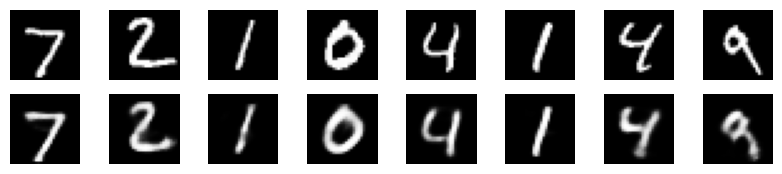

In [4]:
# Define plot function to visualize generated data (reconstructed images)
def plot_reconstructions(epoch):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon_batch, _, _ = model(data)
        comparison = torch.cat([data[:8], recon_batch.view(128, 1, 28, 28)[:8]])
        comparison = comparison.cpu()
        fig, axes = plt.subplots(2, 8, figsize=(10, 2))
        for i in range(8):
            axes[0, i].imshow(comparison[i].squeeze(), cmap='gray')
            axes[1, i].imshow(comparison[i + 8].squeeze(), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].axis('off')
        plt.show()

# Plot
plot_reconstructions(10)
